# Handwritten

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml

<IPython.core.display.Javascript object>

## Create Datasets

In [3]:
# only use 2 of the features
mnist_dataset_config = {
    "meta": {
        "name": "mnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed",
    },
}

mnist_dict_raw = dd.read(mnist_dataset_config)

root dir set to None
as_supervised set to False
with_info set to False


<IPython.core.display.Javascript object>

In [4]:
# only use 2 of the features
fashion_dataset_config = {
    "meta": {
        "name": "fashion_mnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed",
    },
}

fashion_dict_raw = dd.read(fashion_dataset_config)

root dir set to None
as_supervised set to False
with_info set to False


<IPython.core.display.Javascript object>

In [5]:
# only use 2 of the features
kmnist_dataset_config = {
    "meta": {
        "name": "kmnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed",
    },
}

kmnist_dict_raw = dd.read(kmnist_dataset_config)

root dir set to None
as_supervised set to False
with_info set to False


<IPython.core.display.Javascript object>

In [6]:
raw_datadict = {
    "mnist": mnist_dict_raw[0],
    "fashion_mnist": fashion_dict_raw[0],
    "kmnist": kmnist_dict_raw[0],
}

<IPython.core.display.Javascript object>

## alter dataset

In [7]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

<IPython.core.display.Javascript object>

In [8]:
def load_image(datapoint):

    input_image, input_mask = normalize_img(datapoint["image"], datapoint["label"])

    return input_image, input_mask

<IPython.core.display.Javascript object>

In [9]:
ds_dict = {}
for ds_name, raw_dict in raw_datadict.items():
    ds_dict[ds_name] = {}
    for split_name, split_ds in raw_dict.items():
        split_ds = split_ds.map(
            load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

        ds_dict[ds_name][split_name] = split_ds

<IPython.core.display.Javascript object>

## subset

In [10]:
sample_size = 5000
for ds_name, cur_dict in ds_dict.items():
    for split_name, split_ds in cur_dict.items():
        ds_dict[ds_name][split_name] = split_ds.take(sample_size)

<IPython.core.display.Javascript object>

In [11]:
ds_dict

{'mnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>},
 'fashion_mnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>},
 'kmnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>}}

<IPython.core.display.Javascript object>

## Specify the Model

In [12]:
example = "./handwritten_config.yml"
yml_dict = yml.create_configs(example)

config_logger: WARNING  some keys have not been checked for unparsed keys:
 - main_config [model][path] = ./model_config.yml

 This is common when the config contains model:path: <some_path>.yml and means that there could be extra keys in this model config that are not being parsed+used by yeahml. in a future release, this could be addressed by building parsing logic in `src/yeahml/config/create_configs.py`


<IPython.core.display.Javascript object>

## Build the model

In [13]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


<IPython.core.display.Javascript object>

In [14]:
model.summary()

Model: "model_a"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 8)    80          image_in[0][0]                   
__________________________________________________________________________________________________
conv_2_downsample (Conv2D)      (None, 14, 14, 8)    584         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 8)    584         conv_2_downsample[0][0]          
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [15]:
ds_dict

{'mnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>},
 'fashion_mnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>},
 'kmnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>}}

<IPython.core.display.Javascript object>

In [16]:
%%time
train_dict = yml.train_model(model, yml_dict, ds_dict)

train_logger: INFO     START - training
train_logger: INFO     optimizer: fashion_mnist_opt
train_logger: INFO     objective: fashion_mnist_objective
W0810 14:10:16.681819 140498987788096 optimizer_v2.py:1275] Gradients do not exist for variables ['dense_mnist/kernel:0', 'dense_mnist/bias:0', 'dense_kmnist/kernel:0', 'dense_kmnist/bias:0', 'mnist_pred/kernel:0', 'mnist_pred/bias:0', 'kmnist_pred/kernel:0', 'kmnist_pred/bias:0'] when minimizing the loss.
W0810 14:10:16.754243 140498987788096 optimizer_v2.py:1275] Gradients do not exist for variables ['dense_mnist/kernel:0', 'dense_mnist/bias:0', 'dense_kmnist/kernel:0', 'dense_kmnist/bias:0', 'mnist_pred/kernel:0', 'mnist_pred/bias:0', 'kmnist_pred/kernel:0', 'kmnist_pred/bias:0'] when minimizing the loss.
train_logger: INFO     epoch fashion_mnist_objective - fashion_mnist train: 1
train_logger: INFO     done validation - 4992
train_logger: INFO     optimizer: fashion_mnist_opt
train_logger: INFO     objective: fashion_mnist_objective


CPU times: user 1min 2s, sys: 5.66 s, total: 1min 8s
Wall time: 45.5 s


<IPython.core.display.Javascript object>

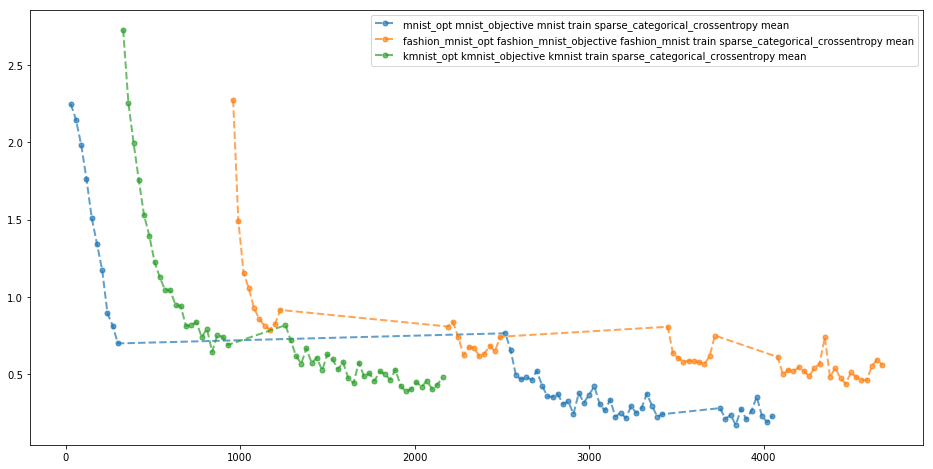

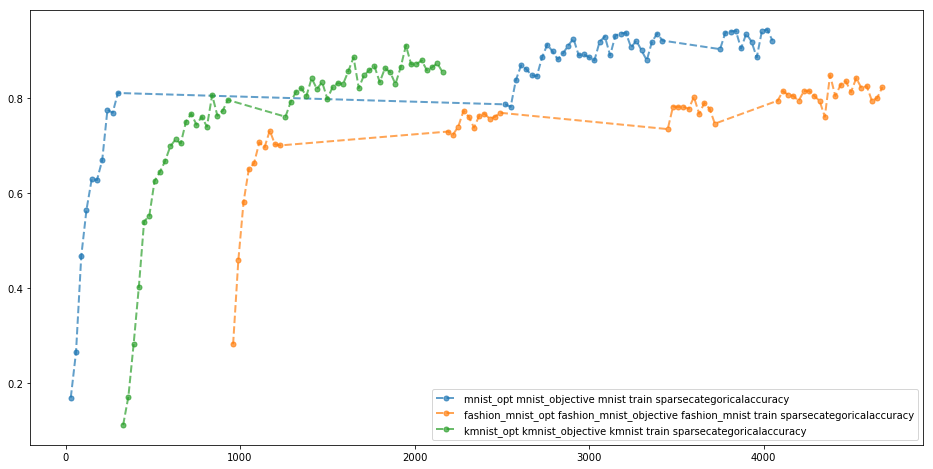

<IPython.core.display.Javascript object>

In [17]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=True,
    validation=False,
    loss=True,
    size=(16, 8),
)

## Evaluate the Model

In [18]:
# eval_dict = yml.eval_model(
#     model,
#     yml_dict,
#     dataset=ds_dict["test"]
# )
# print(eval_dict)

<IPython.core.display.Javascript object>

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```